# Introducing pwangbot

I was chatting with @dff of @tidelift at the NumFocus summit last year, and he suggested classifying @pwang's tweets.  For those who don't know, @pwang tweets alot, and the content is quite good - but it spans a variety of subjects.  If you want to hear @pwang tweet about tech, but not about politics, it can be a problem.  So we're going to collect @pwang tweets, do some topic modeling, and then make some bots!

## Topic Modeling of Tweets




In [1]:
%matplotlib inline
import s3fs
import json
import logging
import tweepy
logging.basicConfig(level=logging.INFO)

In [2]:
from string import punctuation
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import casual_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
en_stop = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stoplist = en_stop.union(set(punctuation))
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
fs = s3fs.S3FileSystem()
root = 'saturn-cloud-data/hugo/pwang-bot-data'
paths = fs.ls(root)

In [4]:
data = []
for p in paths:
    with fs.open(p) as f:
        data.append(json.load(f))

## Tokenization

We do the following - convert everything to lower case words, Throwing out "stop" words, optionally throwing out usernames, urls, and then stemming and lemmatizing.  

In [5]:
en_stop.add('http')
en_stop.add('https')
en_stop.add('co')
en_stop.add('rt')
en_stop.add('like')
en_stop.add('first')
en_stop.add('time')
en_stop.add('next')

def tokenize(x, with_usernames=True):
    for token in casual_tokenize(x):
        if "'" in token:
            token = token.split("'")[0]
        token = token.lower()
        token = stemmer.stem(token)
        if token in en_stop:
            continue
        if not with_usernames:
            if "@" in token:
                continue
        if ":" in token:
            continue
        if len(token) > 3:
            yield lemmatizer.lemmatize(token)

texts = [" ".join(list(tokenize(x['text']))) for x in data]
texts_no_username = [" ".join(list(tokenize(x['text'], with_usernames=False))) for x in data]

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

documents = texts_no_username
no_features = 1000

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words=en_stop)
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [7]:
# Run LDA
from sklearn.decomposition import LatentDirichletAllocation
no_topics = 2
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

/srv/conda/envs/saturn/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [8]:
import numpy as np
# results = np.argmax(nmf.transform(tfidf_vectorizer.transform(texts)), axis=1)
results = np.argmax(lda.transform(tf_vectorizer.transform(texts)), axis=1)

In [ ]:
categorized = {'raw': {}, 'token_no_username': {}, 'token': {}}
for idx, result in enumerate(results):
    categorized['token_no_username'].setdefault(result, []).append(texts_no_username[idx])
    categorized['token'].setdefault(result, []).append(texts[idx])
    categorized['raw'].setdefault(result, []).append(data[idx]['text'])
{len(categorized['raw'][x]) for x in range(no_topics)}

{1563, 1842}

1842


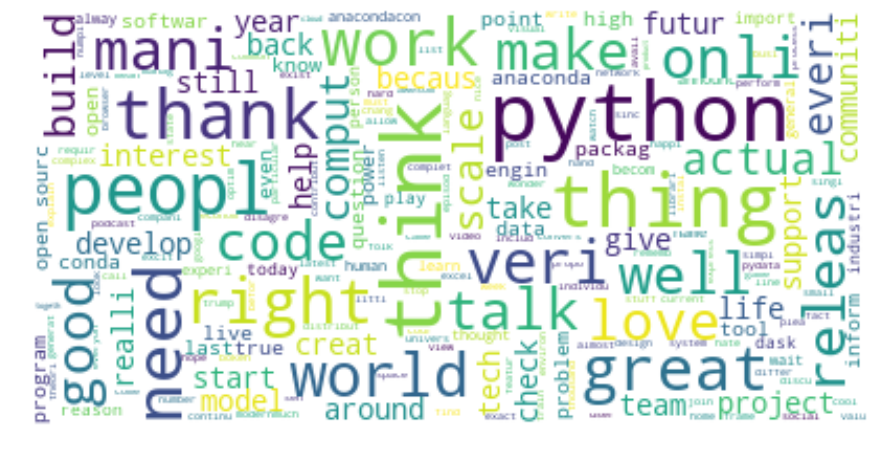

1563


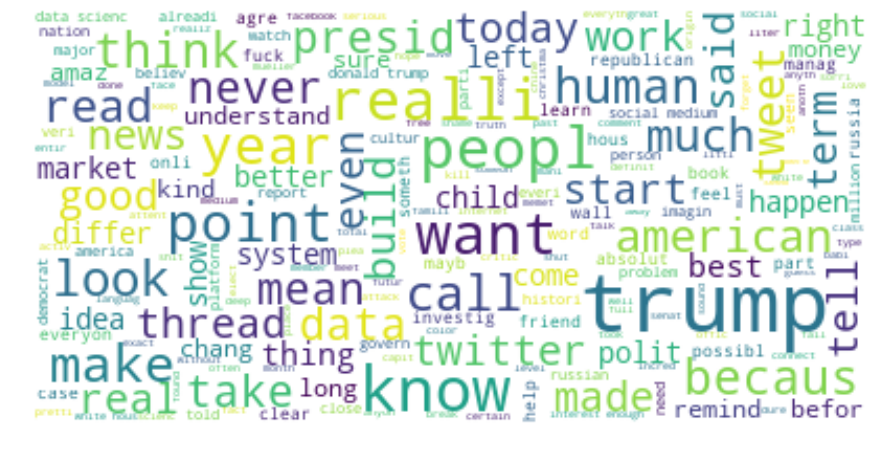

In [ ]:
import os

from os import path
from wordcloud import WordCloud

# Generate a word cloud image
for c in range(no_topics):
    print(len(categorized['token_no_username'][c]))
    text = " ".join(categorized['token_no_username'][c])
    import matplotlib.pyplot as plt
    # lower max_font_size
    wordcloud = WordCloud(background_color="white", max_font_size=40).generate(text)
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()


## Running the bot

So again - you can't run this without your own twitter credentials.  Essentially, every loop we sleep 10 minutes, and then,
we load the 20 most recent tweets.  If there are new tweets, we tokenize them, classify them according to our model,
and tweet them out of the appropriate account.


In [ ]:
# pwangbot_tech is defunct right now - I already have 3 twitter accounts associated with my phone number,
# twitter won't let me add another.  But I get the feeling pwangbot_tech is the more popular option.
accounts = ['pwangbot_tech', "pwangbot_politics"]
with open("/home/jovyan/twitter-creds.json") as f:
    creds = json.load(f)
tapis = []
for a in accounts:
    cred = creds.get(a, None)
    if cred is None:
        tapis.append(None)
        continue
    auth = tweepy.OAuthHandler(cred['consumer_key'], cred['consumer_secret'])
    auth.set_access_token(cred['access_token'], cred['access_token_secret'])
    api = tweepy.API(auth, wait_on_rate_limit=True, timeout=120)
    tapis.append(api)

In [ ]:
max_id = 0
import time
while True:
    new_tweets = tapis[0].user_timeline('pwang')
    new_tweets = [x._json for x in new_tweets if x.id > max_id]
    print ('%s new tweets' % len(new_tweets))
    if len(new_tweets) == 0:
        time.sleep(600)
        continue
    new_tweets = sorted(new_tweets, key=lambda x: x['id'])
    # new_tweets = data
    texts = []
    for tweet in new_tweets:
        text_no_username = " ".join(list(tokenize(tweet['text'], with_usernames=False)))
        texts.append(text_no_username)    
    results = np.argmax(lda.transform(tf_vectorizer.transform(texts)), axis=1)
    for r, tweet in zip(results, new_tweets):
        account = accounts[r]
        api = tapis[r]
        print('tweeting %s to %s' % (tweet['text'], account))
        if api is not None:
            try:
                api.retweet(tweet['id'])
            except tweepy.TweepError as e:
                if e.api_code == 327:
                    print('duplicate retweet')
    max_id = max([x['id'] for x in new_tweets])
    

20 new tweets
tweeting @earino Let me know if you need a sidekick to pwangbot_tech
duplicate retweet
tweeting RT @thisgreyspirit: (1/7) So apparently some (I hope very few) people online are using the fact that I am the primary developer of the eht-… to pwangbot_tech
duplicate retweet
tweeting @chrisalbon @earino Trench coats. to pwangbot_tech
duplicate retweet
tweeting @chrisalbon @earino With Patagonia fleece vests on top. to pwangbot_tech
duplicate retweet
tweeting RT @HerbCarmen: 16 years ago I was on a carrier flying over Iraq in OIF. 2 days in, our former squadronmate died when two helos collided. A… to pwangbot_politics
tweeting I'm an amateur astronomer since the age of 12.

If any company shits all over the sanctity &amp; cosmic beauty of the n… https://t.co/017sOUxmYz to pwangbot_tech
duplicate retweet
tweeting RT @colindcarroll: Part 2 in a series on implementing gradient-based MCMC in Python. Translating @betanalpha's wonderful paper into about 2… to pwangbot_tech
duplicate